In [1]:
%load_ext autoreload
%autoreload 2

import qc_utils as utils
import cirq
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt
import sympy
import itertools
import numpy as np
import json 

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

# Forward

This work follows the arxiV paper:

["Portfolio rebalancing experiments using the Quantum Alternating Operator Ansatz", M. Hodson, B. Ruck, H. Ong, D. Garvin, S. Dulman, arXiV:1911.05296](https://arxiv.org/abs/1911.05296)

# Table of contents

### 1. [The portfolio rebalancing optimization problem](#portfolio_rebalancing)
#### 1.1 [Parameter definitions](#parameter_definitions)
#### 1.2 [Brute force search](#brute_force_search)

### 2. [Construction of QAOA circuit](#construction_of_QAOA_circuit)
#### 2.1 [QAOA grid search](#QAOA_grid_search)
#### 2.2 [QAOA results summary](#QAOA_results_summary)
#### 2.3 [QAOA approximation ratio](#QAOA_approximation_ratio)

### 3. [Construction of AOA circuit](#construction_of_AOA_circuit)
#### 3.1 [AOA grid search](#AOA_grid_search)
#### 3.2 [AOA results summary](#AOA_summary)
#### 3.3 [AOA approximation ratio](#AOA_approximation_ratio)

<a id='portfolio_rebalancing'></a>
# The portfolio rebalancing optimization problem

Suppose there are $N$ risky assets that have a mean return $\mu_k$ and a volatility $\sigma_k$. There is a vector ${\bf z} = [z_1, ..., z_n]$, where $z_k = \lbrace -1,0,1 \rbrace $ that represents our current holdings. A value of $+1 (-1)$ indicates that we currently hold (short) the $k$-th asset and a value of $0$ indicates that we do not take any position for that asset.

The optimal portfolio is the one that minimizes the return-risk cost function $C_{RR}({\bf z})$ given by

$$
C_{RR}({\bf z}) = -\sum_k (1-\lambda) r_k z_k + \lambda\sum_{kj} \sigma_{kj} z_k z_j,
$$


where $0 \leq \lambda \leq 1$ represents an asset manager control parameter that balances the return-risk trade-off, $\lambda=0$ favours returns and $\lambda = 1$ favours the risk.

## The trading costs

The change of the vector ${\bf z}$ incuurs trading fees. Those amount of fees that this change genertes will be given contained in the trading-cost function

$$
C_{TC}({\bf z}) = \sum_j (1-\delta(z_i-y_i))T,
$$


where the vector ${\bf y}$ represents the previous positions of the portfolio, $T$ is the transaction fee and $\delta$ is the discrete Kronecker delta function.

## Trading constraints

The above problem should be solved under the condition that we have a discrete number of assets to be invested

$$
\sum_j z_j =D 
$$

# Function encoding

The variable $z_j = \lbrace -1,0,1\rbrace$ is encoded as a difference of two spin variables 
as

$$
z_j = \frac{1}{2}\left( s^+_j-s^-_j \right),
$$
where 

$$
s^{\pm}_j = \lbrace -1,1 \rbrace.
$$


### Encoding Z as a Qbit pair

The variable $z$ that we are interested in has three values, therefore our entire portfolio state $|\psi \rangle$ will be the product state of qubit pairs

$$
\begin{align}
|\psi\rangle = |z_1\rangle \otimes \cdots |z_N\rangle,
\end{align}
$$
where
$$
|z_k \rangle = |s_{k+}\rangle \otimes |s_{k-}\rangle
$$
and $|s_{k \pm}\rangle$ are the Qubits. In this project I will refer to the $|s_{k+}\rangle$ qubits as the "long-position" qubits, and the $|s_{k-}\rangle$ qubits as the short postion qubits.

### Return-risk function

$$
\begin{align}
C_{RR}({\bf z}) &= -\sum_k (1-\lambda) r_k z_k + \lambda\sum_{kj} \sigma_{kj} z_k z_j, \\
 &= -\sum_k \frac{ (1-\lambda)}{2} r_k\left( s^+_k-s^-_k\right) + \frac{\lambda}{4}\sum_{kj} \sigma_{kj} \left( s^+_k-s^-_k\right) \left( s^+_j-s^-_j\right),
\end{align}
$$

### Soft constraint encoding

$$
\begin{align}
P_{\rm INV}(z) &= A\left(\sum_j z_j-D\right)^2\\
&= A\left(\sum_{jk} z_k z_j-2D\sum_j z_j+D^2 \right)\\
&= \sum_{kj} \frac{A}{4} \left( s^+_k s^+_j-s^+_k s^-_j - s^-_k s^+_j+ s^-_k s^-_j \right) -AD\sum_{j} (s^+_j-s^-_j)+AD^2
\end{align}
$$


The simple method of choosing the the penalty scaling coefficient $A$ is to choose 

$$
A > \text{max}\lbrace C_{RR}({\bf s})+C_{TC}({\bf s}) \rbrace-\text{min}\lbrace C_{RR}({\bf s})+C_{TC}({\bf s}) \rbrace
$$

### Transaction cost encoding

To encode the transcation cost, we factorize the discrete Dirac-delta function as

$$
\delta(z-y) = c_0(z-y-2)(z-y-1)(z-y+1)(z-y+2),
$$

where $z,y \in \lbrace -1,0,1 \rbrace$ noting that $\delta(z-y) =0$ except when $z=y$, where $\delta(z-y) =1$. This implies that

$$
\begin{align}
\delta(z-y) &= \frac{1}{4}(z-y-2)(z-y-1)(z-y+1)(z-y+2),\\
&= \left(\frac{3}{2}y^2-1 \right)z^2+(1-y^2)+\frac{1}{2}yz.
\end{align}
$$

and so,

$$
\begin{align}
C_{TS}(s_i) &= T(1 - \delta(s_i-y_i) ),\\
&= T \left(1-\left(\frac{3}{2}y^2-1 \right)z^2-(1-y^2)-\frac{1}{2}yz \right),\\
&= T \left(-\frac{1}{2}\left(\frac{3}{2}y^2-1 \right)(1-s^+_is^-_i)-y^2-\frac{1}{4}y(s^+_i- s^-_i). \right)
\end{align}
$$

This last function generates all of the correct combinations except for $(y_i,s_i^+,s_i^-)=(0,1,1)$. There we would like this function to generate the value $T$ instead of $0$. To carry this out, we will add a function $g(s_i)$ that is zero for $y^2_i=1$ and for  $y_i,s_i^+,s_i^- = (0,-1,-1),(0,-1,1),(0,-1,1)$. Furthermore,$g(s^+_i,s^-_i)=T$. This function is easily found to be

$$
g(s_i) = \frac{T}{4}\left(1+s^+_i s^-_i +s^-_i +s^+_i \right)(1-y^2_i).
$$


Adding this additional peanlization term, we arrive at the cost-function encoding 

$$
\begin{align}
C_{TS}(s_i) = \frac{1}{4}T\left( 3+(1-y^2_i-y_i)s^{+}_{i}+(1-y^2_i+y_i)s^{-}_{i}+(2y^2_i-1)s^{+}_{i}s^{-}_{i} \right)
\end{align}
$$


In [2]:
# Here we verify that this cost function reproduces all values in the paper 
# by M. Hodson 2019


def C_stored(sm,sp,y):
    '''
    The Tabulated values, (T=1)
    for Table II of Hodson et. al. 2019
    '''
    
    sm = int((sm+1)/2)
    sp = int((sp+1)/2)
    y = y+1
    
    A = np.zeros((3,2,2))
    A[0,0,0]=1
    A[0,0,1]=1
    A[0,1,0]=0
    A[0,1,1]=1
    
    A[1,0,0]=0
    A[1,0,1]=1
    A[1,1,0]=1
    A[1,1,1]=1
    
    A[2,0,0]=1
    A[2,0,1]=0
    A[2,1,0]=1
    A[2,1,1]=1
    
    return A[y,sm,sp]

def C_TC(sm,sp,y):
    '''
    C_{TC}(s,y) function
    
    sm -> s^-_k
    sp -> s^+_k
    
    where:
    sm: {-1,1}
    sp: {-1,1}
    '''
    return 1/4*(3+(1-y**2-y)*sp+(1-y**2+y)*sm+(2*y**2-1)*sp*sm)

# Enumerate all possible input combinations
y_index = [-1,0,1]
sp_index = [-1,1]
sm_index = [-1,1]
combinations = itertools.product(y_index,sp_index,sm_index)

for y,sp,sm in list(combinations):
    print('Function input values: y={}, s^+_k={}, s^-_k={}'.format(y,sp,sm))
    print('Cost function value: {}'.format(C_TC(sm,sp,y))) 
    print('Stored value: {}'.format(C_stored(sm,sp,y)))
    print('')

Function input values: y=-1, s^+_k=-1, s^-_k=-1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=-1, s^+_k=-1, s^-_k=1
Cost function value: 0.0
Stored value: 0.0

Function input values: y=-1, s^+_k=1, s^-_k=-1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=-1, s^+_k=1, s^-_k=1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=0, s^+_k=-1, s^-_k=-1
Cost function value: 0.0
Stored value: 0.0

Function input values: y=0, s^+_k=-1, s^-_k=1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=0, s^+_k=1, s^-_k=-1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=0, s^+_k=1, s^-_k=1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=1, s^+_k=-1, s^-_k=-1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=1, s^+_k=-1, s^-_k=1
Cost function value: 1.0
Stored value: 1.0

Function input values: y=1, s^+_k=1, s^-_k=-1
Cost function value: 0.0
Stored value: 0.0

Funct

# QAOA algorithm

The [Quantum Approximate Optimization Algorithm (QAOA)](https://arxiv.org/abs/1411.4028) is a variational algorithm that allows a quantum computer to determine a reasonably optimal solution in polynomial time to a combinatorical optimization problem. It is unknown at the moment if this algorithm can achieve quantum supremacy in general. The main idea of the algorithm is similar to [Adiabatic Quantum computing](https://en.wikipedia.org/wiki/Adiabatic_quantum_computation), where given the ground state $|\psi_0 \rangle$ of a reference Hamiltonian $H_0$, the time evolution operator acting on $|\psi_0 \rangle$ can evolve this state until it becomes the ground-state wavefunction of the Hamiltonian of interest $H_C$. 

The QAOA algorithm starts from the ground-state wavefunction of a known Hamiltonian
$$
|\psi_0\rangle = |+ \rangle^{\otimes N},
$$
where $ |+ \rangle$ is the positive eigenvalue state of the Pauli operator $\sigma_x$. Therefore in this case we have that the reference Hamiltonian is $H_0=\sum_{i=1}^N \sigma_{x,i}$. Using this state, the QAOA state
$$
\begin{align}
|\psi (\vec{\gamma}, \vec{\beta}) \rangle = \prod_{k=1}^{p} U(B,\beta_k)U(C,\gamma_k)|\psi_0\rangle,
\end{align}
$$
where 
$$
\begin{align}
 U(B,\beta_k) &= \text{Exp}\left( -i \beta_k H_0 \right), \\
 U(C,\gamma_k) &= \text{Exp}\left( -i \gamma_k H_C \right). 
\end{align}
$$
is constructed. The parameter $p$ is the depth of the desired circuit and $\vec{\gamma}$, ${\vec{\beta}}$ are parameters that must be determined classically from the optimization of the energy expectation value
$$
\begin{align}
E = \langle\psi \left(\vec{\gamma}, \vec{\beta}\right) | H_C | \psi \left(\vec{\gamma}, \vec{\beta}\right) \rangle.
\end{align}
$$

The optimization of the angles is carried out using conventional computers and so the QAOA represents a hybrid algorithm. It has been shown that


$$
\begin{align}
\lim_{p \rightarrow \infty}  \text{max}\lbrace \langle\psi \left(\vec{\gamma}, \vec{\beta}\right) | H_C | \psi \left(\vec{\gamma}, \vec{\beta}\right) \rangle \rbrace = \text{max}\lbrace H_C \rbrace
\end{align}
$$

# AOA algorithm

The QAOA algorithm does not naturally incorporate constraints into the formulation. However, it can be modified to do so. This variant of QAOA is called the [Quantum Alternating Operator Ansatz (AOA for our purposes)](https://arxiv.org/abs/1709.03489). In this variant, the mixing operator $U(B,\beta_k)=\text{Exp}(-i\beta_k \sum_i \sigma_{x,i})$ is replaced by another operator that fullfils the following two-properties

* Preserves the feasible subspace. (If the state $|x\rangle$ satifies our constraints, then $U(B,\beta_k)|x\rangle$ also is feasible) 
* The operator $U(B,\beta_k)$ must allow all transitions between all pairs ($|x\rangle,|y\rangle$) of feasible states ($\langle x|U(B,\beta_k) |y \rangle > 0.$)

In addition, the initial state $|\psi_0\rangle$ must now chosen to be in the feasible subspace of solutions. For the $N$-stock portfolio optimization problem with a investment constraint $D$, the following is the initial state

$$
| \psi_0 \rangle = |10\rangle^{\otimes D} \otimes \left( \frac{1}{\sqrt{2}}|00\rangle+\frac{1}{\sqrt{2}}|11\rangle \right)^{\otimes \left(N-D\right)}.
$$

Like the QAOA algorithm, we must create the state
$$
\begin{align}
|\psi\left( \vec{\gamma},\vec{\beta} \right) \rangle = \prod_{k=1}^{p} U(B,\beta_k)U(C,\gamma_k)| \psi_0 \rangle,
\end{align}
$$
where we have that
$$
\begin{align}
 U(C,\gamma_k) &= \text{Exp}\left( -i \gamma_k H_C \right),
\end{align}
$$
as before and
$$
\begin{align}
 U(B,\beta_k) &= U_{\text{long positions}}(B,\beta_k)U_{\text{short positions}}(B,\beta_k), \\
U_{\text{long positions}}(B,\beta_k) &= \prod_{k+} \text{Exp}\left( X_{k+}X_{(k+1)+}+Y_{k+}Y_{(k+1)+} \right),\\
U_{\text{short positions}}(B,\beta_k) &= \prod_{k-} \text{Exp}\left( X_{k-}X_{(k+1)-}+Y_{k-}Y_{(k+1)-} \right).
\end{align}
$$

In [3]:
%load_ext autoreload
%autoreload 2

import qc_utils as utils
import cirq
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt
import sympy
import itertools
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='parameter_definitions'></a>

# Definition of parameters for the notebook

In [4]:
# Do you want to load the data from a file?
load_from_file = True
data_folder = 'results_N8'

# Define the number of portfolios to optimize
N_portfolio = 8

# For the grid search 
N_grid=20
N_trials_grid = 100

N_trials_scipy = 50

# Gradient descent 
N_trials_gd = 50
N_gd_steps = 30
lr = 0.1

# Parameters of the cross-entropy optimizer for the beta, gamma angles 
N_trials_ce = 100
N_ce_iterations = 10
N_ce_samples = 50
f_elite = 0.1

<a id='brute_force_search'></a>

# Brute force search calculation 

Here we compute the optimal solution using a brute-force search.

In [5]:
# Instantiate the portfolio 
portfolio1 = utils.Portfolio(N_portfolio=N_portfolio)

# Get the benchmark parameters
benchmark_parameters = portfolio1.benchmark_values()

# Determine the results via a bruteforce search
best_bruteforce_result = portfolio1.brute_force_search(benchmark_parameters)

# Provide the optimal energy along with the state
print('='*100)
print('Brute-Force state: ', best_bruteforce_result['minimum_cost_states'])
print('Brute-Force energy: ', best_bruteforce_result['minimum_cost'])
print('='*100)

Brute-Force state:  [[1 0 0 0 1 1 1 0]]
Brute-Force energy:  0.0005069200000000001


<a id='construction_of_QAOA_circuit'></a>

# Construct the QAOA circuit 

In this section we use implement the QAOA circuit.

In [6]:
# Generate a QAOA circuit with p=1 depth
QAOA_circuit = portfolio1.QAOA_circuit(p=1)

# plot the circuit
SVGCircuit(QAOA_circuit)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


<a id='QAOA_grid_search'></a>
## Grid search of the angles for $p=1$

For visualization purposes we now conduct a grid-search of the QAOA angle parameters and plot the expected value of the cost function.

In [7]:

# Determine the p=1 energy landscape for the QAOA 
if(load_from_file is True):
    QAOA_results = portfolio1.load_data_from_json(data_folder+'/QAOA_results.json')
else:
    QAOA_results = portfolio1.grid_search(QAOA_circuit,N_grid=N_grid,parameters=benchmark_parameters,n_trials=N_trials_grid)
    portfolio1.save_data_as_json(QAOA_results,data_folder+'/QAOA_results.json')

    
penalty_cost_grid_QAOA = QAOA_results['penalty_cost_grid']
total_cost_grid_QAOA = QAOA_results['total_cost_grid']
best_holdings_QAOA = QAOA_results['min_portfolio_holdings']

gamma_grid = QAOA_results['gamma_grid']
beta_grid = QAOA_results['beta_grid']


Minimum cost solution:  0.04555217900000002
beta: 0.63* pi
gamma: 1.05* pi 


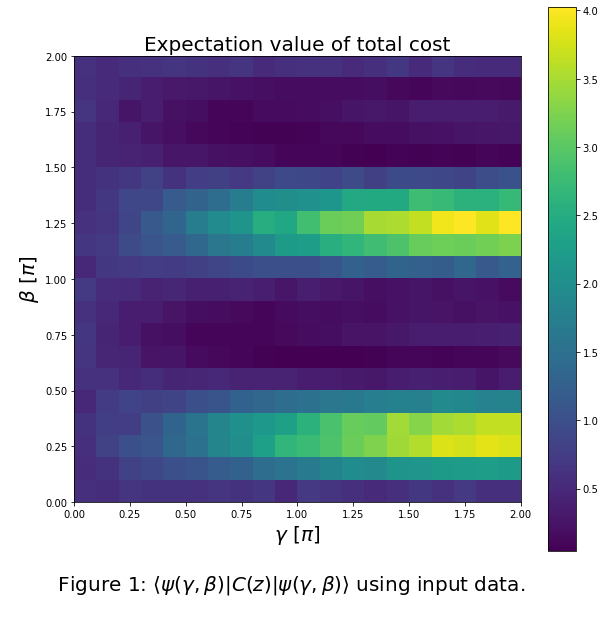

In [8]:
extent = [0.0,2.0, 0.0, 2.0]

print('='*100)
print('Minimum cost solution: ', QAOA_results['minimum_cost'])
print('beta: {:.2f}* pi'.format(QAOA_results['min_betas']/np.pi))
print('gamma: {:.2f}* pi '.format(QAOA_results['min_gamma']/np.pi))
print('='*100)

plt.figure(figsize=(10,10))
plt.title('Expectation value of total cost',size=20)
plt.imshow(total_cost_grid_QAOA[::-1],extent=extent)
plt.colorbar()
plt.xlabel(r'$\gamma \ [\pi]$',size=20)
plt.ylabel(r'$\beta \ [\pi]$',size=20)

text = r'''
        Figure {}: $\langle \psi(\gamma,\beta)|C(z)|\psi(\gamma,\beta) \rangle$ using input data.
        '''.format(1)
plt.text(-.3,-0.5, text, ha='left', size=20)

plt.show()

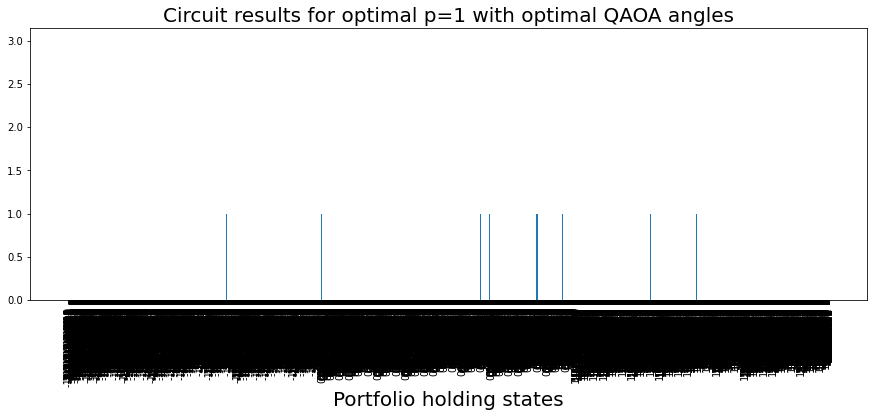

In [9]:
# Show the samples obtained from the experiments with the optimal angles

plt.figure(figsize=(15,5))
plt.title("Circuit results for optimal p=1 with optimal QAOA angles",size=20)
plt.bar(np.arange(len(QAOA_results['min_portfolio_holdings']['labels'])), QAOA_results['min_portfolio_holdings']['counts'], tick_label=QAOA_results['min_portfolio_holdings']['labels'])
plt.xticks(rotation=90)
plt.xlabel('Portfolio holding states',size=20)
plt.show()

In [10]:
# Get the best results from the gridsearch

best_QAOA_result = portfolio1.determine_best_solution_from_trials(benchmark_parameters,best_holdings_QAOA)

print('='*100)
print('QAOA results:')
print('Cost of optimal states: E={:.6f}'.format(best_QAOA_result['minimum_cost']))
print('Minimum energy states: z={}'.format(best_QAOA_result['minimum_cost_states']))
print('Probability of minimum cost states: p={}'.format(best_QAOA_result['minimum_cost_probabilities']))
print('='*100)

QAOA results:
Cost of optimal states: E=0.000512
Minimum energy states: z=[[0 0 1 0 1 1 1 0]]
Probability of minimum cost states: p=[0.01]


In [11]:
p_depth = np.array([1,2,3,4]).astype(int)

QAOA_circuit_p_array = []


# Generate a QAOA circuit with p=1 depth
for p in p_depth:
    QAOA_circuit_p_array.append(portfolio1.QAOA_circuit(p=p))

## Optimize the QAOA cicuit using Scipy optimizer

In [12]:
# Optimize the circuit using Scipy-optimizer
scipy_optimization_array_QAOA= []


if(load_from_file is True):
    
    for p in range(len(p_depth)):
        scipy_optimization_results = portfolio1.load_data_from_json(data_folder+'/QAOA_scipy_p'+str(p)+'.json')
        scipy_optimization_array_QAOA.append(scipy_optimization_results)
else:
    for k in range(len(p_depth)):
        QAOA_circuit_p = QAOA_circuit_p_array[k]
        scipy_optimization_results = portfolio1.optimize_circuit(circuit=QAOA_circuit_p,
                                                             parameters=benchmark_parameters,
                                                             n_trials=N_trials_scipy,
                                                             p=p_depth[k])
        
        print('='*100)
        print('p-depth: ', p_depth[k])
        print('QAOA scipy results:')
        print('Cost of optimal states: E={:.6f}'.format(scipy_optimization_results['best_solutions']['minimum_cost']))
        print('Minimum energy states: z={}'.format(scipy_optimization_results['best_solutions']['minimum_cost_states']))
        print('Probability of minimum cost states: p={}'.format(scipy_optimization_results['best_solutions']['minimum_cost_probabilities']))
        print('='*100)

        scipy_optimization_array_QAOA.append(scipy_optimization_results)

# Save the results to a file
for p in range(len(p_depth)):
    portfolio1.save_data_as_json(scipy_optimization_array_QAOA[p],data_folder+'/QAOA_scipy_p'+str(p)+'.json')

## Optimize the QAOA cicuit using gradient descent (GD) optimization

In [13]:
# Optimize the circuit using Scipy-optimizer
gd_optimization_array_QAOA= []


if(load_from_file is True):
    
    for p in range(len(p_depth)):
        gd_results = portfolio1.load_data_from_json(data_folder+'/QAOA_gd_p'+str(p)+'.json')
        gd_optimization_array_QAOA.append(gd_results)
else:


    for k in range(len(p_depth)):
        QAOA_circuit_p = QAOA_circuit_p_array[k]
        gd_results = portfolio1.optimize_circuit_GD(circuit=QAOA_circuit_p,
                                                    parameters=benchmark_parameters,
                                                    n_trials=N_trials_gd,
                                                    p=p_depth[k],
                                                    lr= lr,
                                                    steps=N_gd_steps)

        print('='*100)
        print('p-depth: ', p_depth[k])
        print('QAOA Gradient Descent results:')
        print('Cost of optimal states: E={:.6f}'.format(gd_results['best_solutions']['minimum_cost']))
        print('Minimum energy states: z={}'.format(gd_results['best_solutions']['minimum_cost_states']))
        print('Probability of minimum cost states: p={}'.format(gd_results['best_solutions']['minimum_cost_probabilities']))
        print('='*100)

        gd_optimization_array_QAOA.append(gd_results)


# Save the results to a file
for p in range(len(p_depth)):
    portfolio1.save_data_as_json(gd_optimization_array_QAOA[p],data_folder+'/QAOA_gd_p'+str(p)+'.json')

## Optimize QAOA cicuit using cross-entropy optimization

In [14]:
ce_optimization_array_QAOA = []



if(load_from_file is True):
    
    for p in range(len(p_depth)):
        ce_results = portfolio1.load_data_from_json(data_folder+'/QAOA_ce_p'+str(p)+'.json')
        ce_optimization_array_QAOA.append(ce_results)
else:
    for k in range(len(p_depth)):
        QAOA_circuit_p = QAOA_circuit_p_array[k]

        ce_results =portfolio1.optimize_circuit_angles_cross_entropy(QAOA_circuit_p,
                                                                     benchmark_parameters,
                                                                     p=p_depth[k],
                                                                     n_trials=N_trials_ce,
                                                                     iterations=N_ce_iterations,
                                                                     f_elite=f_elite,
                                                                     Nce_samples = N_ce_samples)

        print('='*100)
        print('p-depth: ', p_depth[k])
        print('QAOA Cross entropy optimization results:')
        print('Cost of optimal states: E={:.6f}'.format(ce_results['best_solutions']['minimum_cost']))
        print('Minimum energy states: z={}'.format(ce_results['best_solutions']['minimum_cost_states']))
        print('Probability of minimum cost states: p={}'.format(ce_results['best_solutions']['minimum_cost_probabilities']))
        print('='*100)

        ce_optimization_array_QAOA.append(ce_results)


# Save the results to a file
for p in range(len(p_depth)):
    portfolio1.save_data_as_json(ce_optimization_array_QAOA[p],data_folder+'/QAOA_ce_p'+str(p)+'.json')

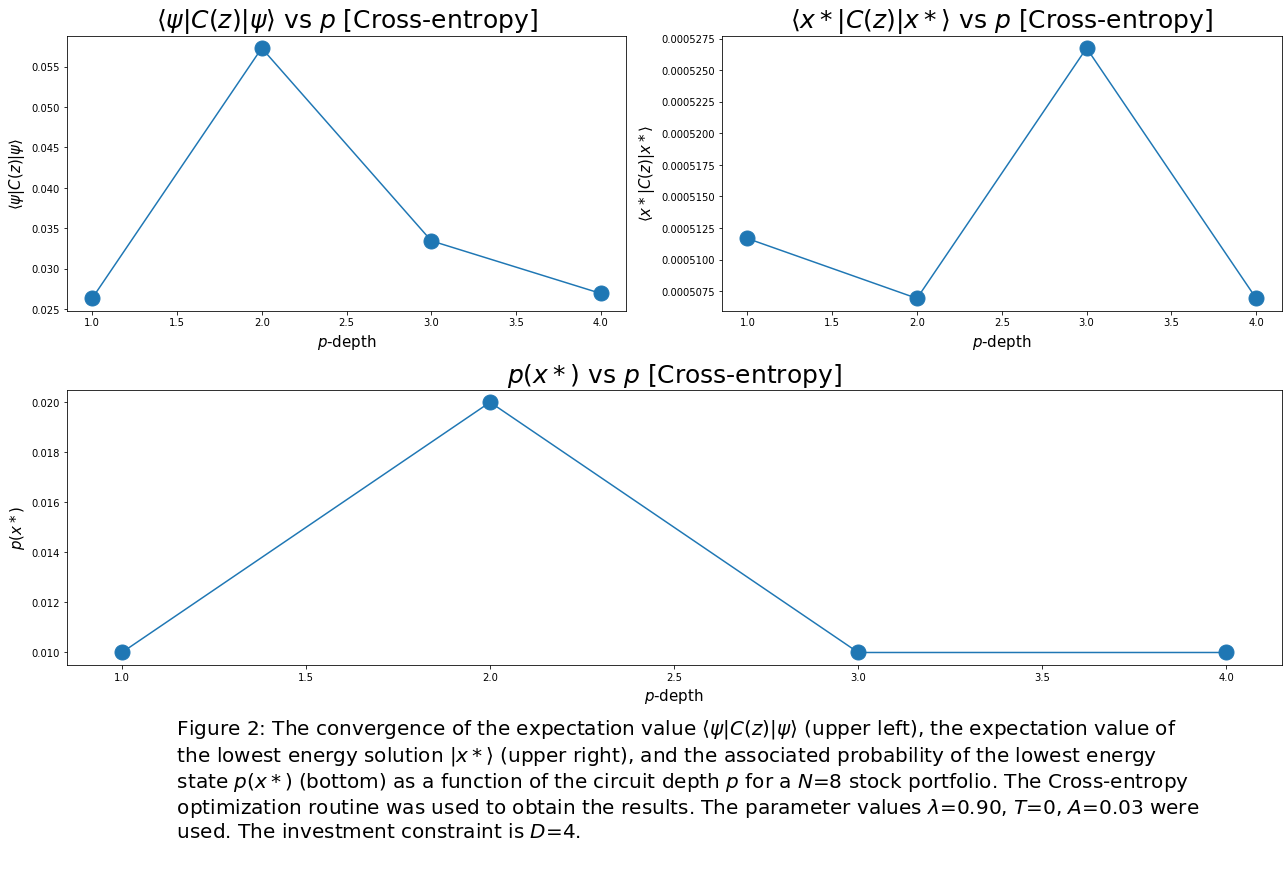

In [15]:
plot_parameters={}
plot_parameters['figure_number'] = 2
plot_parameters['optimizer_name'] = "Cross-entropy"
plot_parameters['optimizer_data'] = ce_optimization_array_QAOA
plot_parameters['p_depth'] = p_depth
plot_parameters['lambda'] = benchmark_parameters['lam']
plot_parameters['D'] = benchmark_parameters['D']
plot_parameters['T'] = benchmark_parameters['T']
plot_parameters['A'] = benchmark_parameters['A']

scipy_plot = portfolio1.plot(plot_parameters)

plt.show()

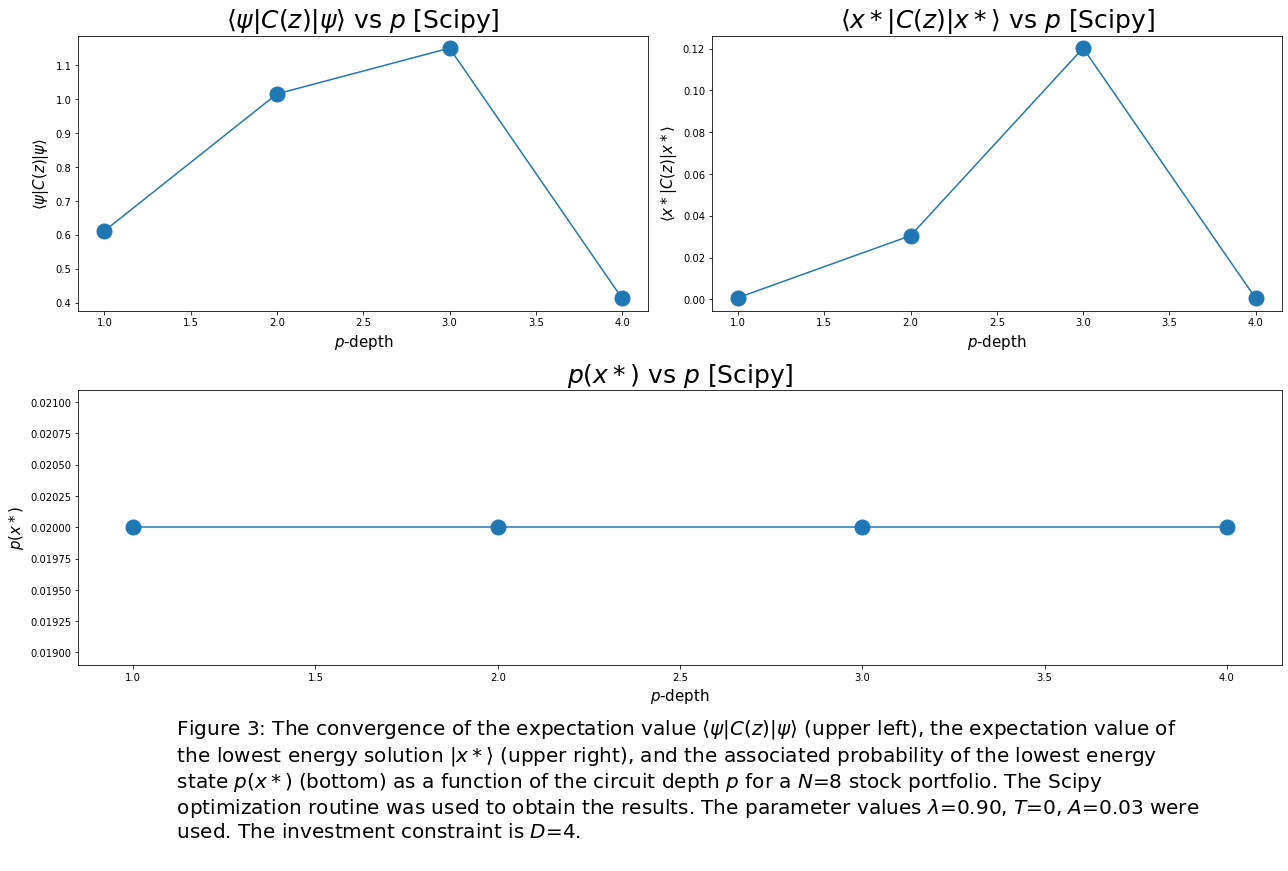

In [16]:
plot_parameters={}
plot_parameters['optimizer_name'] = "Scipy"
plot_parameters['figure_number'] = 3
plot_parameters['optimizer_data'] = scipy_optimization_array_QAOA
plot_parameters['p_depth'] = p_depth
plot_parameters['lambda'] = benchmark_parameters['lam']
plot_parameters['D'] = benchmark_parameters['D']
plot_parameters['T'] = benchmark_parameters['T']
plot_parameters['A'] = benchmark_parameters['A']


scipy_plot = portfolio1.plot(plot_parameters)

plt.show()

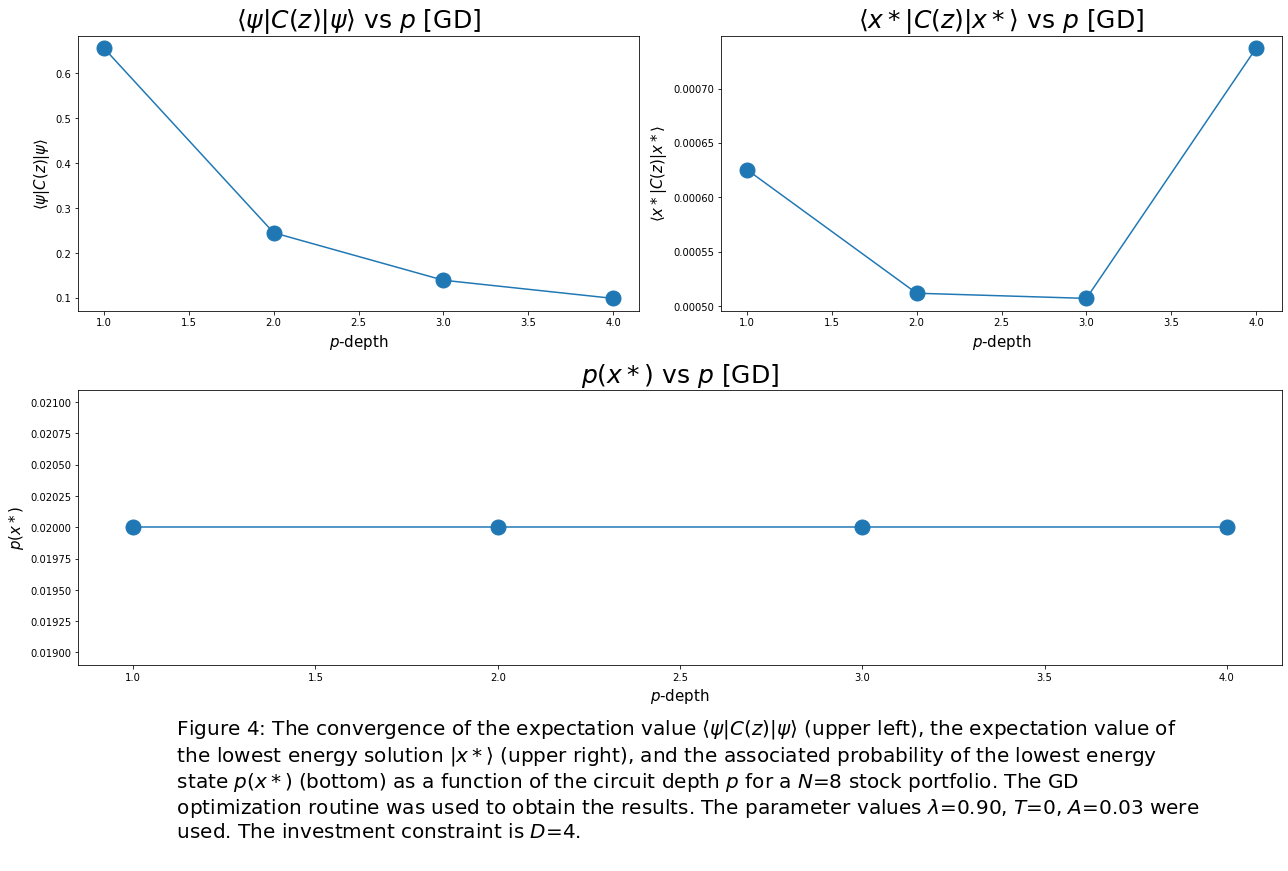

In [17]:
# Gradient descent [GD] applied to the QAOA circuit

plot_parameters={}
plot_parameters['figure_number'] = 4
plot_parameters['optimizer_name'] = "GD"
plot_parameters['optimizer_data'] = gd_optimization_array_QAOA
plot_parameters['p_depth'] = p_depth

plot_parameters['lambda'] = benchmark_parameters['lam']
plot_parameters['D'] = benchmark_parameters['D']
plot_parameters['T'] = benchmark_parameters['T']
plot_parameters['A'] = benchmark_parameters['A']


scipy_plot = portfolio1.plot(plot_parameters)

plt.show()

<a id='QAOA_results_summary'></a>
## Summary of the final QAOA solutions with soft constraints at maximum depth

In [18]:
print('='*100)
print('QAOA-Summary')
print('Maximum depth: ', p_depth[-1])
print('-'*100)
print('Brute-Force optimal solution: ', best_bruteforce_result['minimum_cost_states'])
print()
print('Grid-Search: ', best_QAOA_result['minimum_cost_states'])
print('Probability of best solution: ',best_QAOA_result['minimum_cost_probabilities'])
print('minimum cost solution: ',best_QAOA_result['minimum_cost'])
print()
print('Gradient descent optimizer: ',gd_optimization_array_QAOA[-1]['best_solutions']['minimum_cost_states'])
print('Probability of best solution: ',gd_optimization_array_QAOA[-1]['best_solutions']['minimum_cost_probabilities'])
print('Approximation ratio: ',best_bruteforce_result['minimum_cost']/gd_optimization_array_QAOA[-1]['best_solutions']['minimum_cost'])
print()
print('Scipy-Optimizer: ',scipy_optimization_array_QAOA[-1]['best_solutions']['minimum_cost_states'])
print('Probability of best solution: ',scipy_optimization_array_QAOA[-1]['best_solutions']['minimum_cost_probabilities'])
print('Approximation ratio: ',best_bruteforce_result['minimum_cost']/scipy_optimization_array_QAOA[-1]['best_solutions']['minimum_cost'])
print()
print('Cross-Entropy Optimizer: ',ce_optimization_array_QAOA[-1]['best_solutions']['minimum_cost_states'])
print('Probability of best solution: ',ce_optimization_array_QAOA[-1]['best_solutions']['minimum_cost_probabilities'])
print('Approximation ratio: ',best_bruteforce_result['minimum_cost']/ce_optimization_array_QAOA[-1]['best_solutions']['minimum_cost'])
print('='*100)

QAOA-Summary
Maximum depth:  4
----------------------------------------------------------------------------------------------------
Brute-Force optimal solution:  [[1 0 0 0 1 1 1 0]]

Grid-Search:  [[0 0 1 0 1 1 1 0]]
Probability of best solution:  [0.01]
minimum cost solution:  0.0005116700000000001

Gradient descent optimizer:  [[0, 0, 1, 1, 1, 1, 0, 0]]
Probability of best solution:  [0.02]
Approximation ratio:  0.6876102113344728

Scipy-Optimizer:  [[0, 0, 0, 0, 1, 1, 1, 1]]
Probability of best solution:  [0.02]
Approximation ratio:  0.962335788594426

Cross-Entropy Optimizer:  [[1, 0, 0, 0, 1, 1, 1, 0]]
Probability of best solution:  [0.01]
Approximation ratio:  1.0


<a id='QAOA_approximation_ratio'></a>
## QAOA Approximation ratio

We now plot the approximation ratio of the best solutions using the QAOA algorithm as a function of the circuit depth.

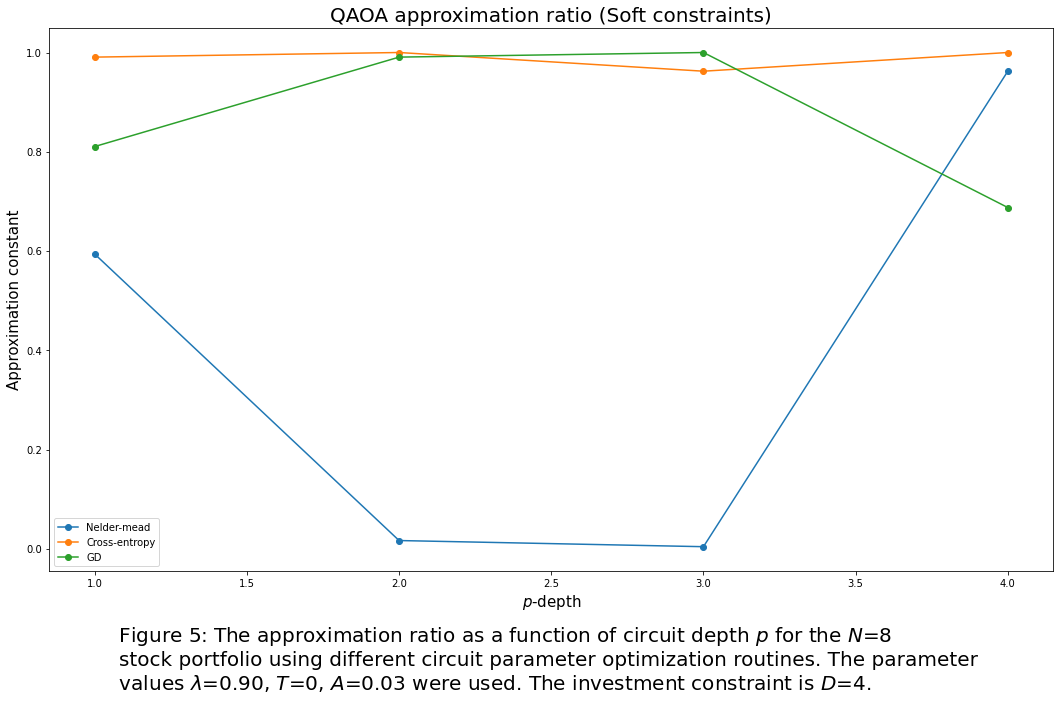

In [19]:
plot_parameters={}
plot_parameters['bruteforce_result'] = best_bruteforce_result
plot_parameters['p_depth'] = p_depth
plot_parameters['optimizers'] = [scipy_optimization_array_QAOA,ce_optimization_array_QAOA,gd_optimization_array_QAOA]
plot_parameters['optimizer_names'] = ['Nelder-mead','Cross-entropy','GD']
plot_parameters['figure_number'] = 5

plot_parameters['lambda'] = benchmark_parameters['lam']
plot_parameters['D'] = benchmark_parameters['D']
plot_parameters['T'] = benchmark_parameters['T']
plot_parameters['A'] = benchmark_parameters['A']
plot_parameters['title'] = "QAOA approximation ratio (Soft constraints)"

fig = portfolio1.plot_approximation_ratio(plot_parameters)
plt.legend()
plt.show()

<a id='AOA_results_summary'></a>
# Construct the AOA Circuit 

Having constructed the QAOA circuit with soft constraints, we proceed to constructing the Quantum alternating operator ansatz to impose the hard constraints. 

In [20]:
# Instantiate the portfolio 
portfolio1 = utils.Portfolio(N_portfolio=N_portfolio)

# Generate a QAOA circuit with p=1 depth
if(N_portfolio%2==0):
    D_const = N_portfolio/2
else:
    D_const = (N_portfolio+1)/2

AOA_circuit = portfolio1.AOA_circuit(p=1,D=D_const)

# plot the circuit
SVGCircuit(AOA_circuit)

<a id='AOA_grid_search'></a>
## Grid search of the angles for $p=1$

For visualization purposes we now conduct a grid-search of the AOA angle parameters and plot the expected value of the cost function.

In [21]:
# Determine the p=1 energy landscape for the QAOA 
if(load_from_file is True):
    AOA_results = portfolio1.load_data_from_json(data_folder+'/AOA_results.json')
else:
    AOA_results = portfolio1.grid_search(AOA_circuit,N_grid=N_grid,parameters=benchmark_parameters,n_trials=N_trials_grid)
    portfolio1.save_data_as_json(AOA_results,data_folder+'/AOA_results.json')


penalty_cost_grid_AOA = AOA_results['penalty_cost_grid']
total_cost_grid_AOA = AOA_results['total_cost_grid']
best_holdings_AOA = AOA_results['min_portfolio_holdings']

gamma_grid = AOA_results['gamma_grid']
beta_grid = AOA_results['beta_grid']

Minimum cost solution:  0.0007310096000000001
beta: 1.79* pi
gamma: 1.26* pi 


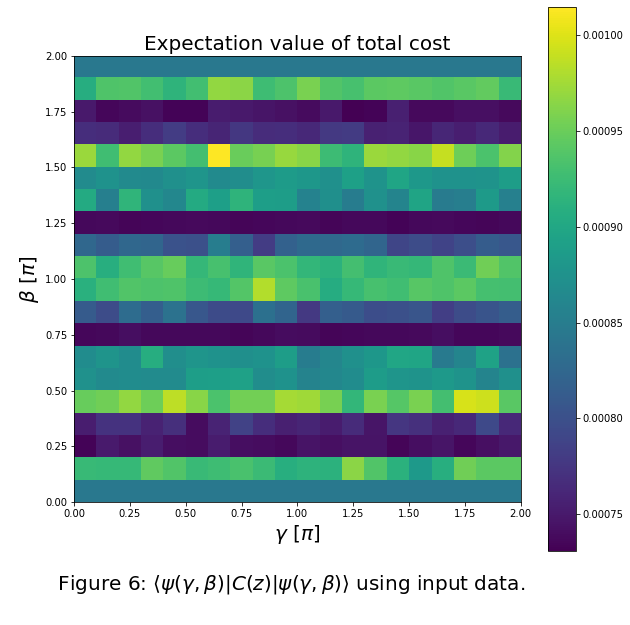

In [22]:
extent = [0.0,2.0, 0.0, 2.0]

print('='*100)
print('Minimum cost solution: ', AOA_results['minimum_cost'])
print('beta: {:.2f}* pi'.format(AOA_results['min_betas']/np.pi))
print('gamma: {:.2f}* pi '.format(AOA_results['min_gamma']/np.pi))
print('='*100)

plt.figure(figsize=(10,10))
plt.title('Expectation value of total cost',size=20)
plt.imshow(total_cost_grid_AOA[::-1],extent=extent)
plt.colorbar()
plt.xlabel(r'$\gamma \ [\pi]$',size=20)
plt.ylabel(r'$\beta \ [\pi]$',size=20)

text = r'''
        Figure {}: $\langle \psi(\gamma,\beta)|C(z)|\psi(\gamma,\beta) \rangle$ using input data.
        '''.format(6)
plt.text(-.3,-0.5, text, ha='left', size=20)
#plt.tight_layout()
plt.show()

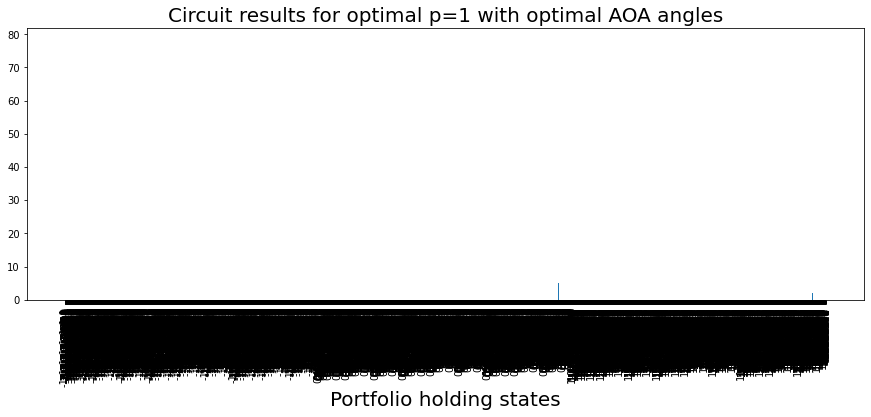

In [23]:
# Show the samples obtained from the experiments with the optimal angles

plt.figure(figsize=(15,5))
plt.title("Circuit results for optimal p=1 with optimal AOA angles",size=20)
plt.bar(np.arange(len(AOA_results['min_portfolio_holdings']['labels'])), AOA_results['min_portfolio_holdings']['counts'], tick_label=AOA_results['min_portfolio_holdings']['labels'])
plt.xticks(rotation=90)
plt.xlabel('Portfolio holding states',size=20)
plt.show()

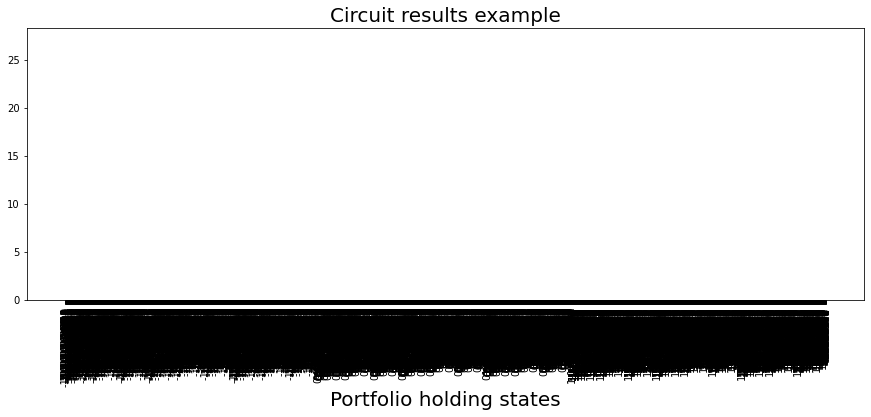

In [24]:
bitstrings = portfolio1.measure_circuit(AOA_circuit,parameters=benchmark_parameters,betas=[0.5],gammas=[0.5],n_trials=N_trials_grid)
portfolio_holdings = portfolio1.convert_bitstrings_to_portfolio_holdings(bitstrings)

plt.figure(figsize=(15,5))
plt.title("Circuit results example",size=20)
plt.bar(np.arange(len(portfolio_holdings['labels'])), portfolio_holdings['counts'], tick_label=portfolio_holdings['labels'])
plt.xticks(rotation=90)
plt.xlabel('Portfolio holding states',size=20)
plt.show()

In [25]:
# Get the best results from the gridsearch

best_AOA_result = portfolio1.determine_best_solution_from_trials(benchmark_parameters,best_holdings_AOA)

print('='*100)
print('QAOA results:')
print('Cost of optimal states: E={:.6f}'.format(best_AOA_result['minimum_cost']))
print('Minimum energy states: z={}'.format(best_AOA_result['minimum_cost_states']))
print('Probability of minimum cost states: p={}'.format(best_AOA_result['minimum_cost_probabilities']))
print('='*100)

QAOA results:
Cost of optimal states: E=0.000602
Minimum energy states: z=[[0 1 1 0 0 1 0 1]]
Probability of minimum cost states: p=[0.08]


In [26]:
p_depth = np.array([1,2,3,4]).astype(int)

AOA_circuit_p_array = []


# Generate a QAOA circuit with p=1 depth
for p in p_depth:
    AOA_circuit_p_array.append(portfolio1.AOA_circuit(D=D_const,p=p))

## Optimize AOA cicuit using Scipy optimizer

In [27]:
# Optimize the AOA circuit using Scipy-optimizer
scipy_optimization_array_AOA= []

if(load_from_file is True):
    
    for p in range(len(p_depth)):
        scipy_optimization_results = portfolio1.load_data_from_json(data_folder+'/AOA_scipy_p'+str(p)+'.json')
        scipy_optimization_array_AOA.append(scipy_optimization_results)
else:

    for k in range(len(p_depth)):
        AOA_circuit_p = AOA_circuit_p_array[k]
        scipy_optimization_results = portfolio1.optimize_circuit(circuit=AOA_circuit_p,
                                                                 parameters=benchmark_parameters,
                                                                 n_trials=N_trials_scipy,
                                                                 p=p_depth[k])

        print('='*100)
        print('p-depth: ', p_depth[k])
        print('AOA scipy results:')
        print('Cost of optimal states: E={:.6f}'.format(scipy_optimization_results['best_solutions']['minimum_cost']))
        print('Minimum energy states: z={}'.format(scipy_optimization_results['best_solutions']['minimum_cost_states']))
        print('Probability of minimum cost states: p={}'.format(scipy_optimization_results['best_solutions']['minimum_cost_probabilities']))
        print('='*100)

        scipy_optimization_array_AOA.append(scipy_optimization_results)

# Save the results to a file
for p in range(len(p_depth)):
    portfolio1.save_data_as_json(scipy_optimization_array_AOA[p],data_folder+'/AOA_scipy_p'+str(p)+'.json')

## Optimize AOA cicuit using cross-entropy optimization

In [28]:
ce_optimization_array_AOA = []


if(load_from_file is True):
    
    for p in range(len(p_depth)):
        ce_results = portfolio1.load_data_from_json(data_folder+'/AOA_ce_p'+str(p)+'.json')
        ce_optimization_array_AOA.append(ce_results)
else:
    
    for k in range(len(p_depth)):
        AOA_circuit_p = AOA_circuit_p_array[k]

        ce_results =portfolio1.optimize_circuit_angles_cross_entropy(AOA_circuit_p,
                                                                     benchmark_parameters,
                                                                     p=p_depth[k],
                                                                     n_trials=N_trials_ce,
                                                                     iterations=N_ce_iterations,
                                                                     f_elite=f_elite,
                                                                     Nce_samples = N_ce_samples)
        print('='*100)
        print('p-depth: ', p_depth[k])
        print('AOA Cross entropy optimization results:')
        print('Cost of optimal states: E={:.6f}'.format(ce_results['best_solutions']['minimum_cost']))
        print('Minimum energy states: z={}'.format(ce_results['best_solutions']['minimum_cost_states']))
        print('Probability of minimum cost states: p={}'.format(ce_results['best_solutions']['minimum_cost_probabilities']))
        print('='*100)

        ce_optimization_array_AOA.append(ce_results)

# Save the results to a file
for p in range(len(p_depth)):
    portfolio1.save_data_as_json(scipy_optimization_array_AOA[p],data_folder+'/AOA_ce_p'+str(p)+'.json')

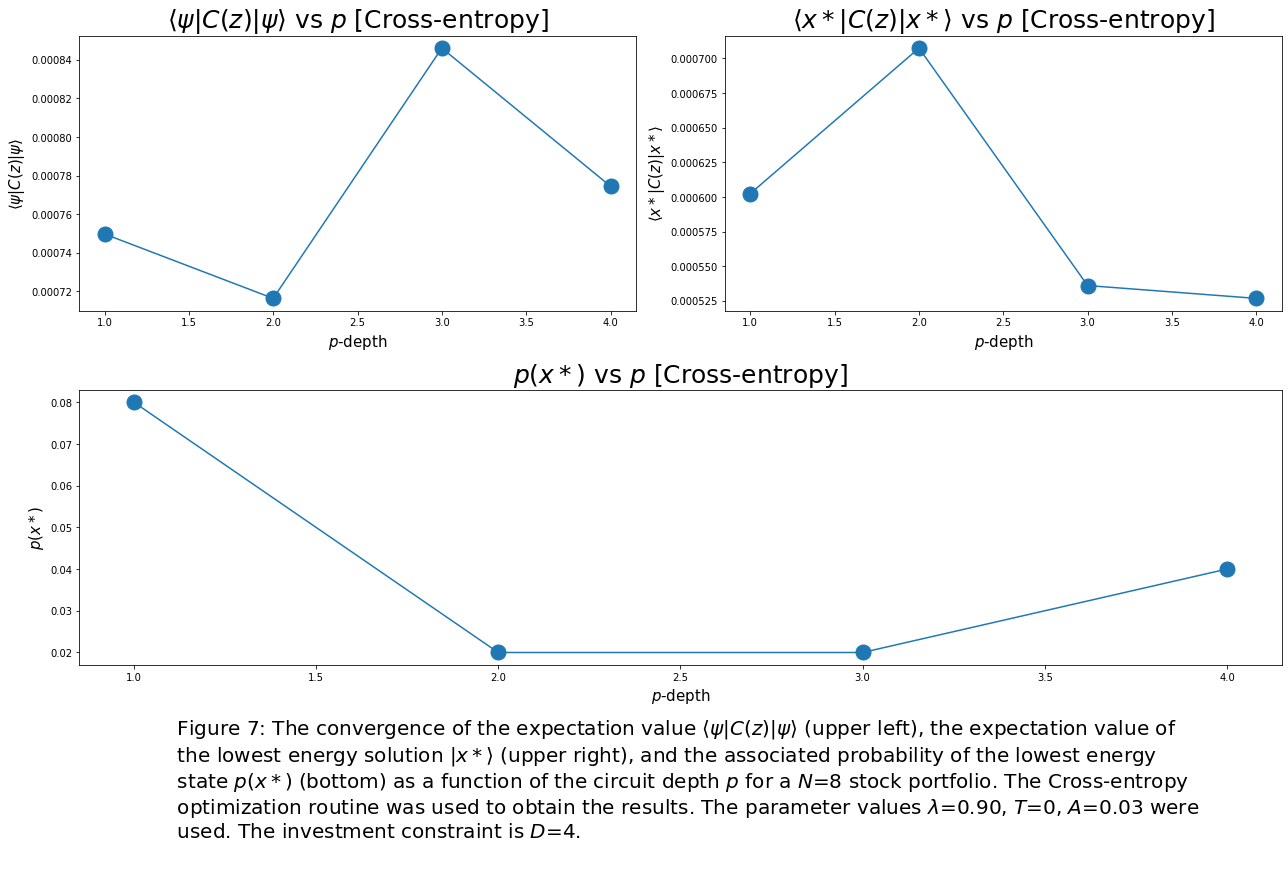

In [29]:
plot_parameters={}
plot_parameters['figure_number'] = 7
plot_parameters['optimizer_name'] = "Cross-entropy"
plot_parameters['optimizer_data'] = ce_optimization_array_AOA
plot_parameters['p_depth'] = p_depth

plot_parameters['lambda'] = benchmark_parameters['lam']
plot_parameters['D'] = benchmark_parameters['D']
plot_parameters['T'] = benchmark_parameters['T']
plot_parameters['A'] = benchmark_parameters['A']


scipy_plot = portfolio1.plot(plot_parameters)

plt.show()

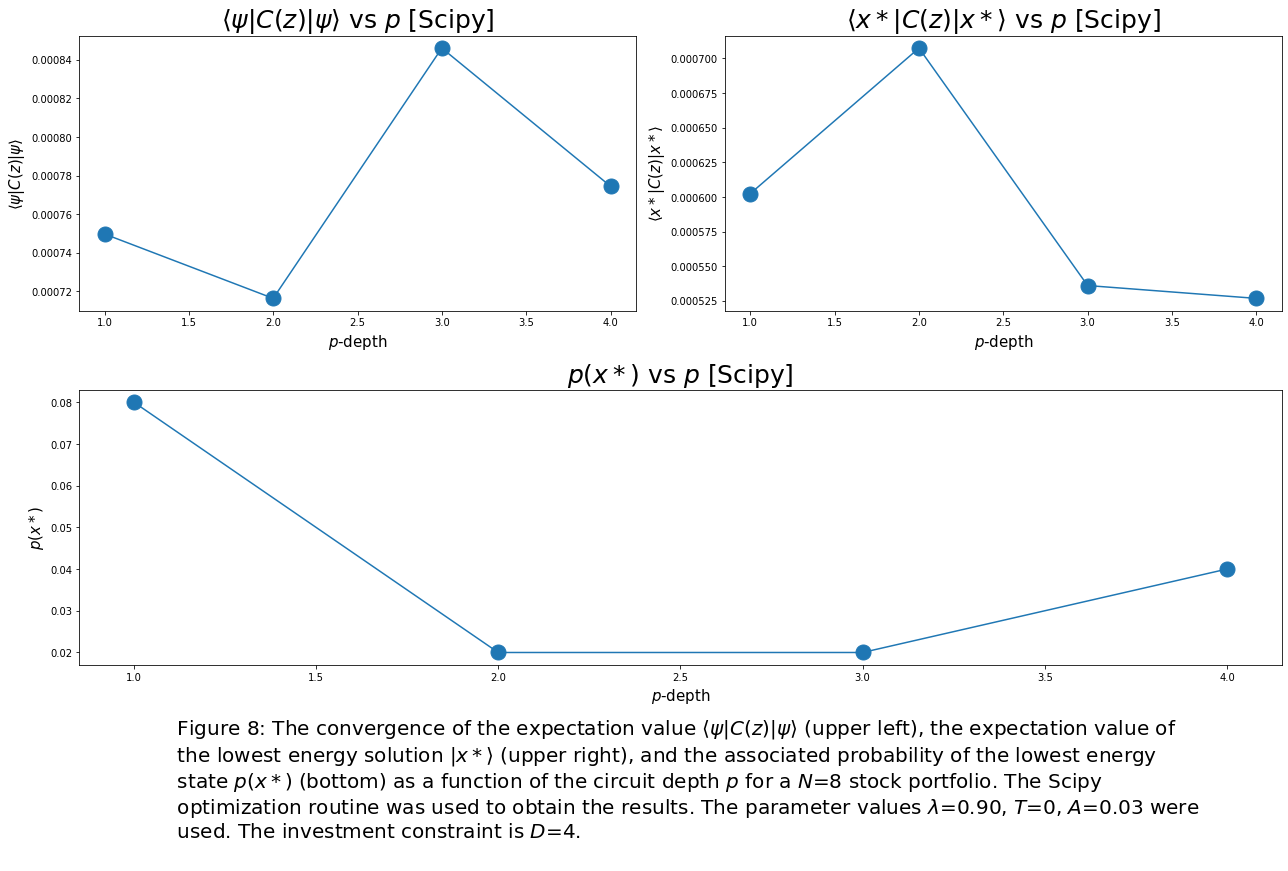

In [30]:
plot_parameters={}
plot_parameters['figure_number'] = 8
plot_parameters['optimizer_name'] = "Scipy"
plot_parameters['optimizer_data'] = scipy_optimization_array_AOA
plot_parameters['p_depth'] = p_depth

plot_parameters['lambda'] = benchmark_parameters['lam']
plot_parameters['D'] = benchmark_parameters['D']
plot_parameters['T'] = benchmark_parameters['T']
plot_parameters['A'] = benchmark_parameters['A']


scipy_plot = portfolio1.plot(plot_parameters)

plt.show()

<a id='AOA_summary'></a>
## Summary of the final AOA solutions with hard constraints at maximum depth

In [31]:
print('='*100)
print('AOA-Summary')
print('Maximum depth: ', p_depth[-1])
print('-'*100)
print('Brute-Force optimal solution: ', best_bruteforce_result['minimum_cost_states'])
print('Brute-Force optimal solution: ', best_bruteforce_result['minimum_cost'])
print()
print('Grid-Search: ', best_AOA_result['minimum_cost_states'])
print('Probability of best solution: ',best_QAOA_result['minimum_cost_probabilities'])
print('Approximation ratio: ',best_bruteforce_result['minimum_cost']/best_QAOA_result['minimum_cost'])
print()
print('Scipy-Optimizer: ',scipy_optimization_array_AOA[-1]['best_solutions']['minimum_cost_states'])
print('Probability of best solution: ',scipy_optimization_array_AOA[-1]['best_solutions']['minimum_cost_probabilities'])
print('Approximation ratio: ',best_bruteforce_result['minimum_cost']/scipy_optimization_array_AOA[-1]['best_solutions']['minimum_cost'])
print()
print('Cross-Entropy Optimizer: ',ce_optimization_array_AOA[-1]['best_solutions']['minimum_cost_states'])
print('Probability of best solution: ',ce_optimization_array_AOA[-1]['best_solutions']['minimum_cost_probabilities'])
print('Approximation ratio: ',best_bruteforce_result['minimum_cost']/ce_optimization_array_AOA[-1]['best_solutions']['minimum_cost'])
print('='*100)

AOA-Summary
Maximum depth:  4
----------------------------------------------------------------------------------------------------
Brute-Force optimal solution:  [[1 0 0 0 1 1 1 0]]
Brute-Force optimal solution:  0.0005069200000000001

Grid-Search:  [[0 1 1 0 0 1 0 1]]
Probability of best solution:  [0.01]
Approximation ratio:  0.9907166728555514

Scipy-Optimizer:  [[0, 0, 0, 0, 1, 1, 1, 1]]
Probability of best solution:  [0.04]
Approximation ratio:  0.962335788594426

Cross-Entropy Optimizer:  [[0, 0, 0, 0, 1, 1, 1, 1]]
Probability of best solution:  [0.04]
Approximation ratio:  0.962335788594426


<a id='AOA_approximation_ratio'></a>
## AOA Approximation ratio

We now plot the approximation ratio of the best solutions using the AOA algorithm as a function of the circuit depth.

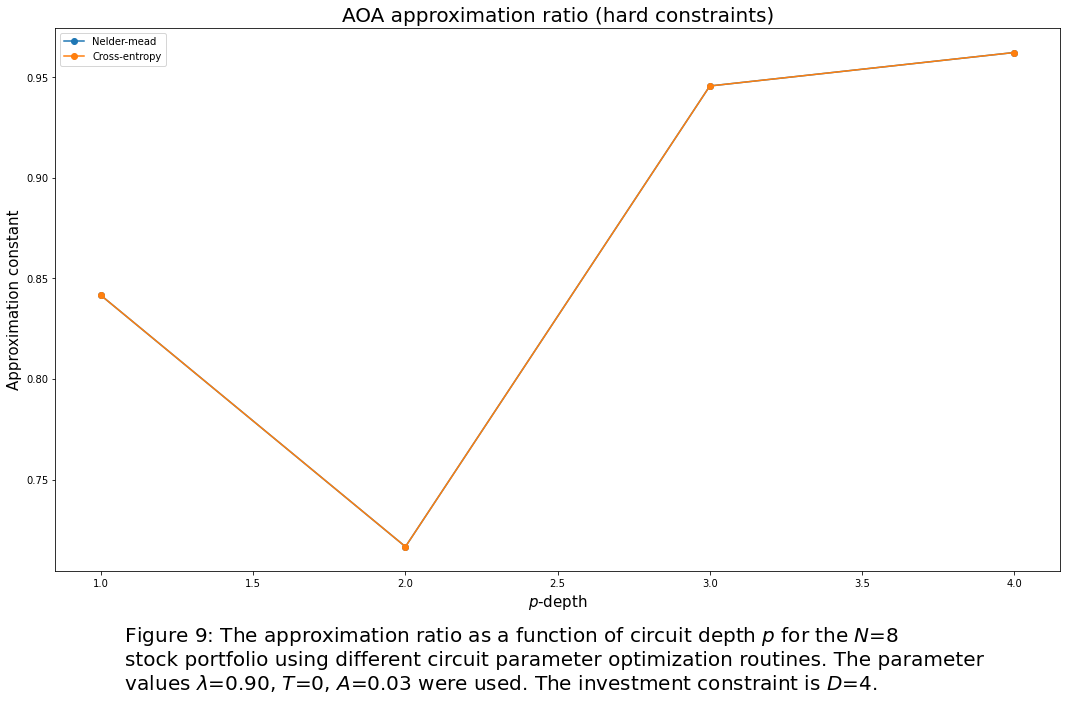

In [32]:
plot_parameters={}
plot_parameters['bruteforce_result'] = best_bruteforce_result
plot_parameters['p_depth'] = p_depth
plot_parameters['optimizers'] = [scipy_optimization_array_AOA,ce_optimization_array_AOA]
plot_parameters['optimizer_names'] = ['Nelder-mead','Cross-entropy']
plot_parameters['figure_number'] = 9

plot_parameters['lambda'] = benchmark_parameters['lam']
plot_parameters['D'] = benchmark_parameters['D']
plot_parameters['T'] = benchmark_parameters['T']
plot_parameters['A'] = benchmark_parameters['A']
plot_parameters['title'] = "AOA approximation ratio (hard constraints)"

fig = portfolio1.plot_approximation_ratio(plot_parameters)
plt.legend()
plt.show()